<a href="https://colab.research.google.com/github/BankNatchapol/CPE393-QuGAN/blob/main/QuGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline



Quantum Generative Adversarial Networks with Cirq + TensorFlow
==============================================================

.. meta::
    :property="og:description": This demo constructs and trains a Quantum
        Generative Adversarial Network (QGAN) using PennyLane, Cirq, and TensorFlow.
    :property="og:image": https://pennylane.ai/qml/_images/qgan3.png

*Author: PennyLane dev team. Last updated: 15 Jan 2021.*

This demo constructs a Quantum Generative Adversarial Network (QGAN)
(`Lloyd and Weedbrook
(2018) <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502>`__,
`Dallaire-Demers and Killoran
(2018) <https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324>`__)
using two subcircuits, a *generator* and a *discriminator*. The
generator attempts to generate synthetic quantum data to match a pattern
of "real" data, while the discriminator tries to discern real data from
fake data (see image below). The gradient of the discriminator’s output provides a
training signal for the generator to improve its fake generated data.

Using Cirq + TensorFlow
-----------------------
PennyLane allows us to mix and match quantum devices and classical machine
learning software. For this demo, we will link together
Google's `Cirq <https://cirq.readthedocs.io/en/stable/>`_ and `TensorFlow <https://www.tensorflow.org/>`_ libraries.

We begin by importing PennyLane, NumPy, and TensorFlow.



In [ ]:
!pip install pennylane-cirq

     |████████████████████████████████| 460kB 11.1MB/s 
     |████████████████████████████████| 389kB 42.9MB/s 
     |████████████████████████████████| 1.5MB 38.2MB/s 
     |████████████████████████████████| 1.3MB 38.8MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
import pennylane as qml
import numpy as np
import tensorflow as tf

We also declare a 3-qubit simulator device running in Cirq.



In [ ]:
dev = qml.device('cirq.simulator', wires=3)

Circuit
---------------------------

In classical GANs, the starting point is to draw samples either from
some "real data" distribution, or from the generator, and feed them to
the discriminator. In this QGAN example, we will use a quantum circuit
to generate the real data.

For this simple example, our real data will be a qubit that has been
rotated (from the starting state $\left|0\right\rangle$) to some
arbitrary, but fixed, state.



### Real part

In [ ]:
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

For the generator and discriminator, we will choose the same basic
circuit structure, but acting on different wires.

Both the real data circuit and the generator will output on wire 0,
which will be connected as an input to the discriminator. Wire 1 is
provided as a workspace for the generator, while the discriminator’s
output will be on wire 2.



### Generator Discriminator

In [ ]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    

We create two QNodes. One where the real data source is wired up to the
discriminator, and one where the generator is connected to the
discriminator. In order to pass TensorFlow Variables into the quantum
circuits, we specify the ``"tf"`` interface.



### Discriminator-Real, Discriminator-Generator

In [ ]:
@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))
  
@qml.qnode(dev)
def gen_cost(gen_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    qml.PauliX(2)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
-------------------

There are two cost functions of interest, corresponding to the two
stages of QGAN training. These cost functions are built from two pieces:
the first piece is the probability that the discriminator correctly
classifies real data as real. The second piece is the probability that the
discriminator classifies fake data (i.e., a state prepared by the
generator) as real.

The discriminator is trained to maximize the probability of
correctly classifying real data, while minimizing the probability of
mistakenly classifying fake data.

\begin{align}Cost_D = \mathrm{Pr}(real|\mathrm{fake}) - \mathrm{Pr}(real|\mathrm{real})\end{align}

The generator is trained to maximize the probability that the
discriminator accepts fake data as real.

\begin{align}Cost_G = - \mathrm{Pr}(real|\mathrm{fake})\end{align}




In [ ]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights_classical, disc_weights) - prob_real_true(disc_weights)
    return cost

Training the QGAN
-----------------

We initialize the fixed angles of the "real data" circuit, as well as
the initial parameters for both generator and discriminator. These are
chosen so that the generator initially prepares a state on wire 0 that
is very close to the $\left| 1 \right\rangle$ state.



In [ ]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
gen_weights_classical = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
gen_weights_quantum = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))                   
disc_weights = np.random.normal(size=(9,))

In [ ]:
gen_weights_quantum = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))     

In [ ]:
gen_weights_classical = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))

We begin by creating the optimizer:



### Classical Discriminator's Gradient

In [ ]:
opt = qml.GradientDescentOptimizer(0.1)

In the first stage of training, we optimize the discriminator while
keeping the generator parameters fixed.



In [ ]:
for step in range(200):
    disc_weights = opt.step(disc_cost, disc_weights)
    if step % 5 == 0:
        cost_val = disc_cost(disc_weights)
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.001386944204568863
Step 5: cost = -0.0016108639538288116
Step 10: cost = -0.0018765628337860107
Step 15: cost = -0.0021944567561149597
Step 20: cost = -0.002576857805252075
Step 25: cost = -0.0030411817133426666
Step 30: cost = -0.003610283136367798
Step 35: cost = -0.004313647747039795
Step 40: cost = -0.005192477256059647
Step 45: cost = -0.006302010267972946
Step 50: cost = -0.007719837129116058
Step 55: cost = -0.009554073214530945
Step 60: cost = -0.011957712471485138
Step 65: cost = -0.015151388943195343
Step 70: cost = -0.019452381879091263
Step 75: cost = -0.025321409106254578
Step 80: cost = -0.03342260420322418
Step 85: cost = -0.0446961373090744
Step 90: cost = -0.060417745262384415
Step 95: cost = -0.08217178657650948
Step 100: cost = -0.11159241199493408
Step 105: cost = -0.14968453347682953
Step 110: cost = -0.195738535374403
Step 115: cost = -0.2464601807296276
Step 120: cost = -0.296471931040287
Step 125: cost = -0.3404484800994396
Step 130: cost = -0.

At the discriminator’s optimum, the probability for the discriminator to
correctly classify the real data should be close to one.



In [ ]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.9641100019216537


For comparison, we check how the discriminator classifies the
generator’s (still unoptimized) fake data:



In [ ]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights_classical, disc_weights).numpy())

Prob(fake classified as real):  0.4986337274312973


In the adversarial game we now have to train the generator to better
fool the discriminator. For this demo, we only perform one stage of the
game. For more complex models, we would continue training the models in an
alternating fashion until we reach the optimum point of the two-player
adversarial game.



### Classical Generator's Gradient

In [ ]:
opt = qml.GradientDescentOptimizer(0.01)

In [ ]:
classical_costs = []
for step in range(200):
    gen_weights_classical = opt.step(gen_cost, gen_weights_classical)
    if step % 5 == 0:
        cost_val = gen_cost(gen_weights_classical).numpy()
        classical_costs.append(cost_val)
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.007160454988479614
Step 5: cost = -0.05657348036766052
Step 10: cost = -0.10570716857910156
Step 15: cost = -0.1543119251728058
Step 20: cost = -0.2021479308605194
Step 25: cost = -0.2489914894104004
Step 30: cost = -0.2946356236934662
Step 35: cost = -0.33889713883399963
Step 40: cost = -0.38161715865135193
Step 45: cost = -0.4226628541946411
Step 50: cost = -0.46192893385887146
Step 55: cost = -0.4993368983268738
Step 60: cost = -0.5348335057497025
Step 65: cost = -0.5683917105197906
Step 70: cost = -0.6000065505504608
Step 75: cost = -0.6296935528516769
Step 80: cost = -0.6574861407279968
Step 85: cost = -0.6834337264299393
Step 90: cost = -0.7075968086719513
Step 95: cost = -0.7300468534231186
Step 100: cost = -0.750862292945385
Step 105: cost = -0.7701276168227196
Step 110: cost = -0.7879294082522392
Step 115: cost = -0.8043559268116951
Step 120: cost = -0.8194953352212906
Step 125: cost = -0.8334355279803276
Step 130: cost = -0.8462609276175499
Step 135: cost = 

### Quantum Generator's Natural Gradient 

In [ ]:
opt = qml.QNGOptimizer(0.01)

In [ ]:
quantum_costs = []
for step in range(200):
    gen_weights_quantum = opt.step(gen_cost, gen_weights_quantum)
    if step % 5 == 0:
        cost_val = gen_cost(gen_weights_quantum).numpy()
        quantum_costs.append(cost_val)
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.0553554892539978
Step 5: cost = -0.24794933199882507
Step 10: cost = -0.4221373200416565
Step 15: cost = -0.568433940410614
Step 20: cost = -0.6838219910860062
Step 25: cost = -0.7705519273877144
Step 30: cost = -0.8336468860507011
Step 35: cost = -0.8787222914397717
Step 40: cost = -0.9107316769659519
Step 45: cost = -0.933538168668747
Step 50: cost = -0.9499441739171743
Step 55: cost = -0.9619007110595703
Step 60: cost = -0.9707383848726749
Step 65: cost = -0.9773586802184582
Step 70: cost = -0.982376292347908
Step 75: cost = -0.9862163877114654
Step 80: cost = -0.989179661963135
Step 85: cost = -0.9914786494337022
Step 90: cost = -0.9932720989454538
Step 95: cost = -0.9946754449047148
Step 100: cost = -0.9957784155849367
Step 105: cost = -0.9966447544284165
Step 110: cost = -0.9973289867630228
Step 115: cost = -0.997868879348971
Step 120: cost = -0.9982954919105396
Step 125: cost = -0.9986330028623343
Step 130: cost = -0.9989000631612726
Step 135: cost = -0.9991118

### Comparison Quantum vs Classical

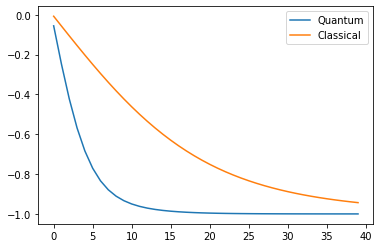

In [ ]:
import matplotlib.pyplot as plt
plt.plot(quantum_costs, label="Quantum")
plt.plot(classical_costs, label="Classical")
plt.legend();

At the optimum of the generator, the probability for the discriminator
to be fooled should be close to 1.



In [ ]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights_quantum, disc_weights).numpy())

Prob(fake classified as real):  0.9999401393033622


At the joint optimum the discriminator cost will be close to zero,
indicating that the discriminator assigns equal probability to both real and
generated data.



In [ ]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.00911780446767807


The generator has successfully learned how to simulate the real data
enough to fool the discriminator.

Let's conclude by comparing the states of the real data circuit and the generator. We expect
the generator to have learned to be in a state that is very close to the one prepared in the
real data circuit. An easy way to access the state of the first qubit is through its
`Bloch sphere <https://en.wikipedia.org/wiki/Bloch_sphere>`__ representation:



In [ ]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev)
bloch_vector_generator = qml.map(generator, obs, dev)

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights_quantum)))

Real Bloch vector: [-0.2169418   0.45048457 -0.86602523]
Generator Bloch vector: [-0.28991744  0.08867157 -0.95290296]


In [ ]:
drawer = qml.draw(real_disc_circuit)
print(drawer(phi, theta, omega, disc_weights))

 0: ──H──────────Rot(0.524, 1.57, 0.449)──H──────────RX(0.296)──RY(-1.26)──RZ(0.864)──╭C─────────────────────────────────────┤     
 2: ──RX(0.135)──RY(0.545)────────────────RZ(-1.31)───────────────────────────────────╰X──RX(2.58)──RY(-0.0172)──RZ(0.0458)──┤ ⟨Z⟩ 



In [ ]:
drawer = qml.draw(gen_disc_circuit)
print(drawer(gen_weights_quantum, disc_weights))

 0: ──H──────────RX(3.14)────RY(1.56)────RZ(-0.18)──╭C──RX(0.0984)──RY(0.288)──RZ(0.0356)──H──RX(0.296)──RY(-1.26)──RZ(0.864)──╭C─────────────────────────────────────┤     
 1: ──RX(0.347)──RY(-0.289)──RZ(-0.904)─────────────╰X─────────────────────────────────────────────────────────────────────────│──────────────────────────────────────┤     
 2: ──RX(0.135)──RY(0.545)───RZ(-1.31)─────────────────────────────────────────────────────────────────────────────────────────╰X──RX(2.58)──RY(-0.0172)──RZ(0.0458)──┤ ⟨Z⟩ 

